In [4]:
import os
import json
import random
import glob
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, Bidirectional, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2

# --- CONFIGURATION ---
# We now look at TWO folders for videos
VIDEO_SOURCE_DIRS = ["videos", "videos_msasl"] 
LANDMARKS_DIR = "landmarks_npy"
os.makedirs(LANDMARKS_DIR, exist_ok=True)

# Model Constraints
SEQ_LEN = 30       # Target length for the model
MAX_FRAMES = 75    # 2.5 seconds @ 30fps (Cut-off for repetitions)
NUM_LANDMARKS = 75 # 33 Pose + 21 Left + 21 Right
TARGET_SAMPLES = 600 # Target count per class (for balancing)

# --- TARGET LIST (30 Words) ---
TARGET_GLOSSES = [
    # Pronouns
    "me", "you", "we", "they", "she",
    # Questions & Interaction
    "who", "what", "yes", "no", "fine", "help", "meet", "good",
    # Verbs
    "want", "have", "like", "need", "go", "walk", 
    "play", "work", "learn", "eat", "drink", "finish",
    # Nouns
    "book", "family", "school", "computer", "deaf"
]
TARGET_GLOSSES = [g.lower() for g in TARGET_GLOSSES]

# --- SYNONYM MAPPING ---
# 'them' videos -> 'they' class
GLOSS_MAPPING = {
    "them": "they"
}

print(f"Configuration Loaded. Targeting {len(TARGET_GLOSSES)} words.")

Configuration Loaded. Targeting 32 words.


In [5]:
# Master list of videos to process: (video_path, target_gloss, video_id)
video_file_list = []
gloss_counts = defaultdict(int)

print("Scanning video folders...")

for source_dir in VIDEO_SOURCE_DIRS:
    if not os.path.exists(source_dir):
        print(f"Warning: Folder '{source_dir}' not found. Skipping.")
        continue
        
    # Walk through GLOSS subfolders
    # Structure: source_dir / GLOSS / video.mp4
    for root, dirs, files in os.walk(source_dir):
        # The folder name is the gloss (e.g., "BOOK" or "book")
        folder_name = os.path.basename(root).lower()
        
        # 1. Resolve Synonyms
        target_gloss = folder_name
        if folder_name in GLOSS_MAPPING:
            target_gloss = GLOSS_MAPPING[folder_name]
            
        # 2. Check if it's a target
        if target_gloss in TARGET_GLOSSES:
            for file in files:
                if file.endswith((".mp4", ".mov", ".avi")):
                    full_path = os.path.join(root, file)
                    vid_id = os.path.splitext(file)[0]
                    
                    # Add to master list
                    video_file_list.append({
                        "path": full_path,
                        "gloss": target_gloss,
                        "id": vid_id
                    })
                    gloss_counts[target_gloss] += 1

print(f"\nFound {len(video_file_list)} videos total.")
print("-" * 30)
print("Breakdown by Class:")
for gloss in TARGET_GLOSSES:
    print(f"{gloss:<10}: {gloss_counts[gloss]}")

Scanning video folders...

Found 2467 videos total.
------------------------------
Breakdown by Class:
me        : 40
you       : 54
we        : 36
they      : 35
hello     : 55
who       : 59
what      : 63
yes       : 69
no        : 73
fine      : 57
help      : 63
meet      : 49
good      : 62
want      : 67
have      : 51
like      : 70
need      : 66
go        : 55
walk      : 57
play      : 52
work      : 48
learn     : 63
eat       : 75
drink     : 74
finish    : 76
book      : 85
family    : 67
school    : 70
computer  : 66
deaf      : 71
j         : 323
z         : 316


In [6]:
mp_holistic = mp.solutions.holistic

def extract_landmarks(results):
    """Extracts pose, left_hand, right_hand into a flat vector."""
    vec = []
    # Pose (33 landmarks * 3 coords)
    if results.pose_landmarks:
        for lm in results.pose_landmarks.landmark:
            vec.extend([lm.x, lm.y, lm.z])
    else:
        vec.extend([0.0] * 99)
    # Left Hand (21 * 3)
    if results.left_hand_landmarks:
        for lm in results.left_hand_landmarks.landmark:
            vec.extend([lm.x, lm.y, lm.z])
    else:
        vec.extend([0.0] * 63)
    # Right Hand (21 * 3)
    if results.right_hand_landmarks:
        for lm in results.right_hand_landmarks.landmark:
            vec.extend([lm.x, lm.y, lm.z])
    else:
        vec.extend([0.0] * 63)
    return vec

print("Starting extraction...")
with mp_holistic.Holistic(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1) as holistic:
    
    for item in video_file_list:
        vid_id = item["id"]
        gloss = item["gloss"]
        video_path = item["path"]
        
        # Output file: landmarks_npy/video_id.npy
        # Note: We use video_id to avoid overwriting if MSASL and WLASL share names
        # To be safe, we can prefix: msasl_video_id vs wlasl_video_id
        prefix = "msasl" if "msasl" in video_path.lower() else "wlasl"
        unique_name = f"{prefix}_{vid_id}"
        npy_path = os.path.join(LANDMARKS_DIR, f"{unique_name}.npy")
        
        # SKIP if exists
        if os.path.exists(npy_path):
            continue
            
        cap = cv2.VideoCapture(video_path)
        frames_data = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break
            
            # Process
            results = holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            frames_data.append(extract_landmarks(results))
            
        cap.release()
        
        if len(frames_data) > 0:
            np.save(npy_path, np.array(frames_data, dtype=np.float32))
            print(f"Extracted: {unique_name} ({gloss})")

print("Extraction complete.")

Starting extraction...
Extraction complete.


In [7]:
# 1. Re-Scan the NPY folder to see what we actually have
valid_samples = [] # (filename, gloss)

# We need to map "unique_name" back to "gloss". 
# Since we didn't save gloss in the filename, we can infer it or rely on the master list logic.
# Better approach: Iterate the master list and check if the npy exists.

processed_count = 0
for item in video_file_list:
    vid_id = item["id"]
    gloss = item["gloss"]
    prefix = "msasl" if "msasl" in item["path"].lower() else "wlasl"
    unique_name = f"{prefix}_{vid_id}"
    npy_path = os.path.join(LANDMARKS_DIR, f"{unique_name}.npy")
    
    if os.path.exists(npy_path):
        valid_samples.append((unique_name, gloss))
        processed_count += 1

print(f"Valid extracted samples: {processed_count}")

# 2. Group by Gloss
gloss_map = defaultdict(list)
for vid_name, gloss in valid_samples:
    gloss_map[gloss].append(vid_name)

# 3. Stratified Split
train_vids = []
val_vids = []

for gloss, vids in gloss_map.items():
    if len(vids) < 3:
        train_vids.extend([(v, gloss) for v in vids])
        continue
    
    t_vids, v_vids = train_test_split(vids, test_size=0.2, random_state=42)
    train_vids.extend([(v, gloss) for v in t_vids])
    val_vids.extend([(v, gloss) for v in v_vids])

print(f"Training set: {len(train_vids)} videos")
print(f"Validation set: {len(val_vids)} videos")

Valid extracted samples: 2467
Training set: 1961 videos
Validation set: 506 videos


In [8]:
def pre_process_landmarks(data):
    """
    Standard pre-processing: Cap duration, Interpolate, Body-Centric Norm.
    """
    # 1. Duration Capping
    if len(data) > MAX_FRAMES:
        data = data[:MAX_FRAMES]
    
    # 2. Interpolation
    df = pd.DataFrame(data)
    df = df.replace(0.0, np.nan)
    df = df.interpolate(method='linear', axis=0, limit_direction='both')
    df = df.fillna(0.0)
    data = df.values.astype(np.float32)
    
    # Reshape
    frames = data.reshape(-1, NUM_LANDMARKS, 3)
    
    # 3. Body-Centric Normalization
    for i in range(frames.shape[0]):
        frame = frames[i]
        left_shoulder = frame[11]
        right_shoulder = frame[12]
        shoulder_center = (left_shoulder + right_shoulder) / 2.0
        width = np.linalg.norm(left_shoulder - right_shoulder) + 1e-6
        
        frame = (frame - shoulder_center) / (width / 2.0)
        frames[i] = frame

    return frames.reshape(-1, NUM_LANDMARKS * 3)

def resize_sequence(sequence, target_len=SEQ_LEN):
    norm_seq = pre_process_landmarks(sequence)
    res = np.zeros((target_len, norm_seq.shape[1]))
    for j in range(norm_seq.shape[1]):
        res[:, j] = np.interp(
            np.linspace(0, len(norm_seq)-1, target_len),
            np.arange(len(norm_seq)),
            norm_seq[:, j]
        )
    return res

# --- NEW: MIRRORING LOGIC ---
def mirror_sequence(sequence):
    """
    Flips the sign horizontally to simulate a left-handed signer.
    1. Flip X coords.
    2. Swap Left/Right Landmarks.
    """
    seq = sequence.copy().reshape(-1, NUM_LANDMARKS, 3)
    
    # 1. Flip X-axis (assuming normalized data centered at 0)
    seq[:, :, 0] *= -1 
    
    # 2. Swap Left/Right Body Landmarks (Pose)
    # MediaPipe Pose Pairs (Left <-> Right) to swap
    # Indices: 1-3(Eyes), 7(Ear) <-> 4-6(Eyes), 8(Ear), etc.
    # Shoulders(11,12), Elbows(13,14), Wrists(15,16), Pinky(17,18)...
    
    # Map of corresponding indices
    left_pose  = [1,2,3,7,9,11,13,15,17,19,21,23,25,27,29,31]
    right_pose = [4,5,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
    
    # Swap pose points
    seq[:, left_pose + right_pose, :] = seq[:, right_pose + left_pose, :]
    
    # 3. Swap Hand Blocks (Left Hand <-> Right Hand)
    # Left Hand indices: 33 to 53
    # Right Hand indices: 54 to 74
    left_hand_idx = list(range(33, 54))
    right_hand_idx = list(range(54, 75))
    
    seq[:, left_hand_idx + right_hand_idx, :] = seq[:, right_hand_idx + left_hand_idx, :]
    
    return seq.reshape(-1, NUM_LANDMARKS*3)

def augment_data(sequence):
    """Apply random scaling, rotation, translation, AND Mirroring."""
    seq = sequence.copy().reshape(-1, NUM_LANDMARKS, 3)
    
    # --- PROBABILISTIC MIRRORING (50% chance) ---
    if random.random() > 0.5:
        # We process the mirroring on the reshaped sequence directly here
        # (Re-using the logic from mirror_sequence for efficiency)
        seq[:, :, 0] *= -1
        left_pose  = [1,2,3,7,9,11,13,15,17,19,21,23,25,27,29,31]
        right_pose = [4,5,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
        seq[:, left_pose + right_pose, :] = seq[:, right_pose + left_pose, :]
        left_hand_idx = list(range(33, 54))
        right_hand_idx = list(range(54, 75))
        seq[:, left_hand_idx + right_hand_idx, :] = seq[:, right_hand_idx + left_hand_idx, :]
    
    # --- STANDARD AUGMENTATION ---
    # Scaling
    seq[:, :, 0] *= random.uniform(0.8, 1.2)
    seq[:, :, 1] *= random.uniform(0.8, 1.2)
    
    # Translation
    seq[:, :, 0] += random.uniform(-0.1, 0.1)
    seq[:, :, 1] += random.uniform(-0.1, 0.1)

    # Rotation
    theta = random.uniform(-0.15, 0.15)
    c, s = np.cos(theta), np.sin(theta)
    for t in range(seq.shape[0]):
        x, y = seq[t, :, 0], seq[t, :, 1]
        seq[t, :, 0] = x*c - y*s
        seq[t, :, 1] = x*s + y*c
            
    return seq.reshape(-1, NUM_LANDMARKS*3)

In [9]:
X_train, y_train = [], []
X_val, y_val = [] , []

label_map = {label: num for num, label in enumerate(TARGET_GLOSSES)}

# --- 1. Group Training Data ---
train_by_gloss = defaultdict(list)
for vid, gloss in train_vids:
    train_by_gloss[gloss].append(vid)

# --- 2. Process Training (Balanced) ---
print("Processing Training Data...")
for gloss, vids in train_by_gloss.items():
    if not vids: continue
    
    # Calculate Oversampling
    num_videos = len(vids)
    aug_per_video = int(TARGET_SAMPLES / num_videos)
    # Ensure at least 1 augmentation if we have lots of videos
    if aug_per_video < 1: aug_per_video = 1
    
    # print(f"  - {gloss}: {num_videos} videos -> {aug_per_video}x aug")
    
    for vid in vids:
        path = os.path.join(LANDMARKS_DIR, f"{vid}.npy")
        if not os.path.exists(path): continue
        data = np.load(path)
        
        # Add Original
        X_train.append(resize_sequence(data))
        y_train.append(label_map[gloss])
        
        # Add Augmentations
        for _ in range(aug_per_video - 1):
            aug = augment_data(resize_sequence(data))
            X_train.append(aug)
            y_train.append(label_map[gloss])

# --- 3. Process Validation (No Augmentation) ---
print("Processing Validation Data...")
for vid, gloss in val_vids:
    path = os.path.join(LANDMARKS_DIR, f"{vid}.npy")
    if not os.path.exists(path): continue
    data = np.load(path)
    
    X_val.append(resize_sequence(data))
    y_val.append(label_map[gloss])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

print(f"Final Training Shape: {X_train.shape}")
print(f"Final Validation Shape: {X_val.shape}")

Processing Training Data...
Processing Validation Data...
Final Training Shape: (18380, 30, 225)
Final Validation Shape: (506, 30, 225)


In [ ]:
model = Sequential()

# 1. Feature Extraction (CNN)
model.add(Conv1D(64, 5, padding='same', input_shape=(SEQ_LEN, NUM_LANDMARKS*3), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization()) 
model.add(Activation('relu'))
model.add(Dropout(0.3))

# 2. Temporal Learning (Bi-LSTM)
model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.001))))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# 3. Classification
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(len(TARGET_GLOSSES), activation='softmax'))

model.summary()

# Optimization
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    ModelCheckpoint("word_model.keras", save_best_only=True, monitor="val_loss", mode="min"),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Train
history = model.fit(
    X_train, y_train, 
    epochs=1000, 
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

C:\Users\User\Desktop\JUPYTER NOTEBOOK\my_venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 30, 64)              │          72,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 30, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 446,176 (1.70 MB)

 Trainable params: 445,280 (1.70 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/1000
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.1299 - loss: 4.0306 - val_accuracy: 0.3142 - val_loss: 3.0765 - learning_rate: 1.0000e-04
Epoch 2/1000
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.2968 - loss: 3.2219 - val_accuracy: 0.4091 - val_loss: 2.6754 - learning_rate: 1.0000e-04
Epoch 3/1000
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.4200 - loss: 2.7474 - val_accuracy: 0.4921 - val_loss: 2.3348 - learning_rate: 1.0000e-04
Epoch 4/1000
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.5039 - loss: 2.4237 - val_accuracy: 0.5316 - val_loss: 2.1357 - learning_rate: 1.0000e-04
Epoch 5/1000
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.5669 - loss: 2.1654 - val_accuracy: 0.5375 - val_loss: 2.1897 - learning_rate: 1.0000e-04
Epoch 6/1000
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.6100 - loss: 1.9540 - val_accuracy: 0.5534 - val_loss: 2.0808 - learning_rate: 1.0000e-04
Epoch 7/1000
1149/1149 ━━━━━

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

--- Classification Report ---
              precision    recall  f1-score   support

          me       0.75      0.75      0.75         8
         you       0.38      0.27      0.32        11
          we       1.00      0.75      0.86         8
        they       1.00      1.00      1.00         7
         she       0.00      0.00      0.00         2
         who       0.69      0.75      0.72        12
        what       0.80      0.62      0.70        13
         yes       0.47      0.64      0.55        14
          no       0.85      0.73      0.79        15
        fine       0.75      0.75      0.75        12
        help       0.92      0.85      0.88        13
        meet       1.00      0.90      0.95        10
        good       0.75      0.69      0.72        13
        want       0.80      0.86      0.83        14
        have       1.00      0.91      0.95        11
        like       0.73      0.79      0.76        14
        ne

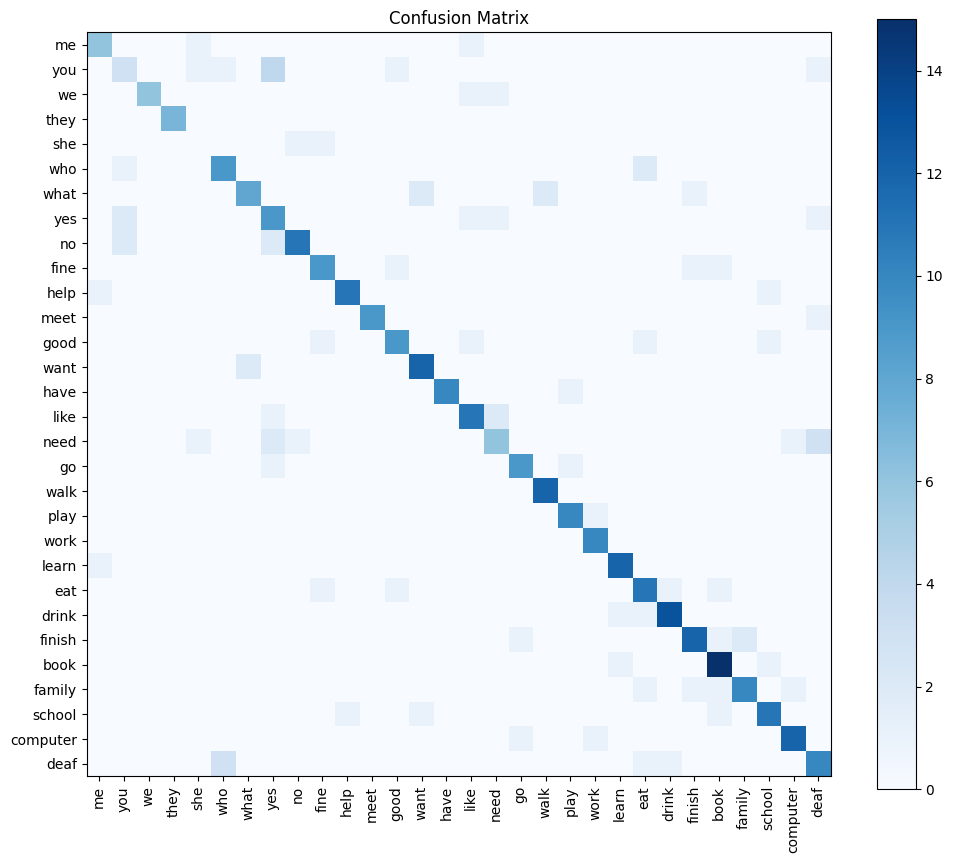

Model saved as word_model.h5


In [16]:
# Load best weights
model.load_weights("word_model.keras")

# Predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Report
print("\n--- Classification Report ---")
print(classification_report(y_val, y_pred_classes, target_names=TARGET_GLOSSES))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_val, y_pred_classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(TARGET_GLOSSES))
plt.xticks(tick_marks, TARGET_GLOSSES, rotation=90)
plt.yticks(tick_marks, TARGET_GLOSSES)
plt.show()

# Save final model for deployment
model.save("word_model.h5")
print("Model saved as word_model.h5")

In [26]:
import json

# Load the dataset metadata
with open('WLASL_v0.3.json', 'r') as f:
    wlasl_data = json.load(f)

# Define pronouns to check
pronouns = ['i', 'me', 'you', 'my', 'she', 'mine', 'we', 'us', 'they', 'them', 'my', 'your', 'his', 'her', 'our', 'their']

print(f"{'GLOSS':<10} | {'INSTANCES':<10} | {'UNIQUE SIGNERS':<15}")
print("-" * 40)

for target in pronouns:
    # Find the entry for this gloss
    entry = next((item for item in wlasl_data if item['gloss'].lower() == target), None)
    
    if entry:
        instances = entry['instances']
        unique_signers = set()
        for inst in instances:
            if 'signer_id' in inst:
                unique_signers.add(inst['signer_id'])
        
        print(f"{target:<10} | {len(instances):<10} | {len(unique_signers):<15}")
    else:
        print(f"{target:<10} | {'NOT FOUND':<10} | {'-'}")

GLOSS      | INSTANCES  | UNIQUE SIGNERS 
----------------------------------------
i          | 7          | 7              
me         | 9          | 9              
you        | 16         | 13             
my         | 12         | 12             
she        | 9          | 8              
mine       | 7          | 7              
we         | 10         | 10             
us         | NOT FOUND  | -
they       | 9          | 9              
them       | 8          | 8              
my         | 12         | 12             
your       | 15         | 10             
his        | 8          | 6              
her        | 11         | 8              
our        | 7          | 7              
their      | 10         | 7              


In [2]:
import tensorflow as tf
import os

# --- CONFIGURATION ---
INPUT_MODEL_PATH = "best_model.h5"
OUTPUT_DIR = "word_model_tf"  # This will be a folder

# 1. Load the model
if os.path.exists(INPUT_MODEL_PATH):
    print(f"Loading {INPUT_MODEL_PATH}...")
    model = tf.keras.models.load_model(INPUT_MODEL_PATH)
    
    # 2. EXPORT (The Keras 3 way)
    # This creates the standard TF SavedModel folder structure
    # containing 'saved_model.pb' and 'variables/'
    model.export(OUTPUT_DIR)
    
    print(f"Success! Model exported to '{OUTPUT_DIR}'")
    print(f"Contents: {os.listdir(OUTPUT_DIR)}")
    
else:
    print(f"Error: Could not find {INPUT_MODEL_PATH}")

Loading best_model.h5...
INFO:tensorflow:Assets written to: word_model_tf\assets


INFO:tensorflow:Assets written to: word_model_tf\assets


Saved artifact at 'word_model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 225), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 30), dtype=tf.float32, name=None)
Captures:
  2762144571536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2762144573840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2762144574032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2762144574992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2762144572112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2762144573072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2762144576912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2762144576144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2762144578256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2762144574608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2762144575568: TensorSpec(shape=(), dtype